<img src="../../Img/backdrop-wh.png" alt="Drawing" style="width: 300px;"/>

<div style="display: block; width: 100%; height: 100px;">

<p style="float: left;">
    <span style="font-weight: bold; font-size: 20px;">
        DIGHUM160 - Critical Digital Humanities 
        <br />
        Instructor: Tom van Nuenen<br />
        Final Project
    </span>
</p>

**Project title:** ```Memes, Discussion, and Worldviews: An Exploration of r/HistoryMemes```

**Student name:** ```Jay Sahaym```

Word limit: Between 2500 and 3000 words (excluding code cells, outputs, and references).


In [49]:
import os
import pandas as pd
import spacy
import nltk
from nltk.corpus import stopwords
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import string
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from operator import itemgetter
from scipy import spatial
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import inflect
import numpy as np
import statistics
import itertools
from datetime import datetime
import statistics
import nltk.data
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
nlp = spacy.load('en_core_web_sm')

## Introduction

Reddit is a platform with a wide variety of forums known as subreddits, each focused on a specific topic. One of the largest humor-based subreddits is r/HistoryMemes. This subreddit is devoted to posting jokes and memes about history and historical events. As a meme-based forum, humor is the dominant tone and style of comments and posts. However, the subject matter lends itself to more serious discussions on historical records and politics. User views are revealed through the language in their posts and comments. One would expect that an online forum, with potential contributors ostensibly coming from a wide range of backgrounds, would have a similarly broad spectrum of worldviews or political opinions. Anecdotally, however, this hypothesis is not well supported. Instead, there is evidence that a common perspective is created and perpetuated through participation in the subreddit.

<table><tr>
<td> <img src="figures/civilwarmeme.png" width="400" /> Figure 1.a: Meme about the Civil War</td>
<td> <img src="figures/typicalthread.png" width="400" /> Figure 1.b: Typical comment thread under Figure 1.a  </td>
<td> <img src="figures/controversialcomm.png" width="400" />
Figure 1.c: Downvoted thread under 1.a</td>
</tr></table>

In other forms of discourse, the public opinions of the American Civil War can be contentious. For example, states such as Idaho, Texas, and Louisiana have all had bills that limited education about slavery progress through state legislatures with significant support. However, the vast majority of the comment threads under Figure 1.a, one of the highest upvoted posts in the subreddit, all support the same historical view depicted in Figure 1.b, which claims that the Civil War was caused by the southern states' desire to maintain the system of slavery. Dissenting opinions are downvoted and therefore ignored by the vast majority of users, as seen in Figure 1.c. This post is just one example of the subreddit's promotion of a specific interpretation of historical events.

### Positionality/Previous Knowledge/Assumptions
Through my previous interactions with the community, I have observed that the memes and jokes generally address widely known topics, specifically Western military history. I have especially noticed that both World Wars and the United States are very often referenced in posts on the subreddit. This observation is likely a reflection of the skewed user demographics (Western and younger) of Reddit as a whole; users make jokes based on what they know best, which is mostly what they have been taught in their school system. Fitting a meme-based subreddit, the language is heavily influenced by internet culture (e.g., “based”, “UNO reverse”) and for the most part somewhat juvenile. However, I noticed that there were two main types of comments: those that were or related to jokes and memes and those that were more focused on the actual historical event mentioned in the post. The latter type tended to be formal and in some cases academic, but also had some biases that could be interesting to explore. The subreddit rules, enforced by moderators, ban antagonistic comments that one might expect from a history-based subreddit. From a cursory glance, the subreddit seems to have limited antagonistic conflicts, though there are jokes shared at the expense of specific countries/cultures depending on the post. In general, I would claim that the redditors that specifically frequent r/HistoryMemes tend to be liberal or leftist in their political affiliation.

### Research Questions
This project will attempt to describe the key elements of the shared culture of the subreddit using several different computational methods. Following the discovery of these points, I will identify the many ways in which the culture is created and perpetuated through the analysis of several posts and comments. Another avenue of exploration will be to look at the biases of comments. There are two main types of comments: jokes or memes and more serious historical discussion. Jokes and memes are worth analyzing for bias, but the more formal historical debates will likely be of more relevance. Using the worldview characteristics observed from language analysis, I will try to construct an image of the average r/HistoryMemes user to get a better understanding of the factors that contribute to the shared historical and political narrative of the subreddit.

### Dataset Information
The dataset I have chosen to use for this project is a CSV file containing the comments from the subreddit r/HistoryMemes. The comments contain the majority of interactions that actual users of Reddit have with the subreddit. Comment sections are where the discussions involving multiple users occur. Therefore, the comments would be the most responsible in promoting a shared worldview if there is one. Comments are also nicely categorized by Reddit itself. The upvote system provides a clear metric for how the subreddit approves of a comment, whereas a particularly controversial post, i.e. one that engenders heated discussion, may have a high score due to a desire for user interaction in the comments of that post.

While it would have added another dimension to the paper, subreddit post data was not able to be used in the context of the project. The largest stumbling block was the lack of text in each post. This is a feature of r/HistoryMemes that was unsurprisingly reflected in the dataset; if each post is a meme, then they contain an image, with the only text involved being the title. I could have included the titles, but they are often not informational. Titles of posts could be related to the historical content, but more often tended to be related to another joke or the meme format itself. An example of an unhelpful title can be seen in Figure 2 below. Though the title, "They overestimated it." does explain the joke, it does not reference the Cold War, or aircraft, or the military. Any tokens that would be obtained from such a title would not be distinguishing in any way.

<img src="figures/unhelpfultitle.png" width="400" /> 
Figure 2: A post with an unhelpful title.

## Analysis

### Preprocessing


In [3]:
# Loading comments
comms_df = pd.read_csv('data/HistoryMemesData/comments.csv')
comms_df.head(5)

C:\Users\Jay Sahaym\AppData\Local\Temp\ipykernel_3752\448898949.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  comms_df = pd.read_csv('data/HistoryMemesData/comments.csv')


,idint,idstr,created,author,parent,submission,body,score,subreddit,distinguish,textlen
0,2.650028e+10,t1_c69l239,1347917692,Zrk2,t3_101kzp,t3_101kzp,I'm so sorry.,2.0,HistoryMemes,NaN,13.0
1,2.650039e+10,t1_c69neao,1347926661,Zrk2,t3_101my1,t3_101my1,Too bad most of these will be pretty much one-...,1.0,HistoryMemes,NaN,57.0
2,2.661457e+10,t1_c85mltf,1359471648,kjoneslol,t3_173cpi,t3_173cpi,I've removed this. It should be a historical m...,1.0,HistoryMemes,moderator,160.0
3,2.665805e+10,t1_c8viijd,1363275514,kjoneslol,t3_1aa96t,t3_1aa96t,"I've removed this\n\n>Remember, this is the me...",1.0,HistoryMemes,moderator,256.0
4,2.667551e+10,t1_c95wqkh,1364764260,[deleted],t3_1a1zp3,t3_1a1zp3,[deleted],1.0,HistoryMemes,NaN,9.0


In [4]:
# removing moderator comments by making a list of indices and then dropping those rows
modlist = comms_df.loc[comms_df['distinguish'].str.contains("moderator", case=False, na=False)].index.tolist()
comms_df = comms_df.drop(modlist).reset_index(drop=True)

# removing deleted comments
del_list = comms_df.loc[comms_df['body'] == '[deleted]'].index.tolist()
comms_df = comms_df.drop(del_list).reset_index(drop=True)

comms_df.head(5)

,idint,idstr,created,author,parent,submission,body,score,subreddit,distinguish,textlen
0,2.650028e+10,t1_c69l239,1347917692,Zrk2,t3_101kzp,t3_101kzp,I'm so sorry.,2.0,HistoryMemes,NaN,13.0
1,2.650039e+10,t1_c69neao,1347926661,Zrk2,t3_101my1,t3_101my1,Too bad most of these will be pretty much one-...,1.0,HistoryMemes,NaN,57.0
2,2.668747e+10,t1_c9d16x8,1365690678,mustaphadancer,t3_1bovjy,t3_1bovjy,ask a russian who won the war.,1.0,HistoryMemes,NaN,30.0
3,2.668747e+10,t1_c9d17fv,1365690718,mustaphadancer,t3_1a1zp3,t3_1a1zp3,i got 99 problems but a bitch ain't one,0.0,HistoryMemes,NaN,40.0
4,2.669945e+10,t1_c9k5xbp,1366620680,Krastain,t3_1cti4f,t3_1cti4f,Looks terribly circlejerky.,1.0,HistoryMemes,NaN,28.0


In [5]:
#split df into positive scores df and negative scores df
neg_df = comms_df[comms_df['score'] < 0].reset_index()

In [6]:
pos_df = comms_df[comms_df['score'] > 75].reset_index()

Along with the dataframe consisting of all comments in the data set, I have also decided to utilize two subframes. The criteria for these subframes is the score column, representing the quantity of upvotes or downvotes received by a comment. The negative dataframe contains those comments with a score of less than zero. The positive dataframe contains comments with a score of more than 75. There is a very large quantity of comments with a slightly positive score. These comments are not necessarily influential in the subreddit, and have therefore been removed. Splitting the total comments dataframe in such a way enables a more nuanced analysis. Breaking down the data allows for tokens to be represented when they may have been sidelined. Additionally, similar tokens could be used in both the positive data and the negative data. However, looking at each set of data separately allows for different conclusions to be drawn from the use of such tokens. For example, the token "slavery" may be used very often overall. However, if it appears in the negative comments topic model and not the positive topic model, then we may infer that downvoted pro-slavery comments often appear in the subreddit.

In [1]:
# function to clean and lemmatize text
stop_words = set(stopwords.words('english'))
punct_list = " ".join(string.punctuation).split()
def cleanandlemma(text, lemmas):
    toReplace = ["…", "–", "—", "\n"] + punct_list
    for char in toReplace:
        text = text.replace(char, ' ')
    parsed_com = nlp(text)
    tokens = [token.lemma_ for token in parsed_com]
    for tok in tokens:
        if tok.isalpha() == False:
            tokens.remove(tok)
            #print(tokens)
        elif tok in stop_words:
            tokens.remove(tok)
        elif tok in string.punctuation:
            tokensremove(tok)    
    lemmas.append(tokens)

NameError: name 'stopwords' is not defined

In [9]:
# function to collect lemmas into a list
def lemmaCollector(column, lemmas):
    for i in column:
        if str(type(i)) != "<class 'str'>":
            pass
        else:
            cleanandlemma(i, lemmas)

In [10]:
lemmas_pos = []
lemmas_neg = []
lemmaCollector(pos_df['body'], lemmas_pos)
lemmaCollector(neg_df['body'], lemmas_neg)

In [ ]:
# additional check for blank space tokens
for i in lemmas_neg:
    for w in i:
        if w in stop_words or w == " ":
            i.remove(w)

In [ ]:
# additional check for blank space tokens
for i in lemmas_pos:
    for w in i:
        if w in stop_words or w == " ":
            i.remove(w)

### Topic Modeling


In [13]:
# negative score topic model
dictionary = corpora.Dictionary(lemmas_neg)#lemmas_split)
    

dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify() 


dictionary.save(f'historymemes_neg_lda.dict')


corpus = [dictionary.doc2bow(text) for text in lemmas_neg]

%time
lda_model = LdaModel(corpus=corpus,
                id2word=dictionary,       
                num_topics=5,            
                random_state=100,         
                passes=2,                 
                per_word_topics=False)    




CPU times: total: 0 ns
Wall time: 0 ns


In [51]:
# viz of model
pyLDAvis.enable_notebook()

lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

C:\Users\Jay Sahaym\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.133530 -0.174068       1        1  28.708194
4      0.085432  0.054079       2        1  28.234984
1     -0.019047  0.288898       3        1  17.258882
3      0.177742 -0.071415       4        1  15.689662
2     -0.377656 -0.097494       5        1  10.108277, topic_info=        Term          Freq         Total Category  logprob  loglift
50         I  41379.000000  41379.000000  Default  30.0000  30.0000
98     https   5807.000000   5807.000000  Default  29.0000  29.0000
135        r   5624.000000   5624.000000  Default  28.0000  28.0000
0        com   3368.000000   3368.000000  Default  27.0000  27.0000
61       war   7597.000000   7597.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
404   Soviet    514.892198    840.699022   Topic5  -5.4895   1.8015
1406       3    422.238749    600.335917   Topic5  -5.6879   1.9399
256      win    551.379014   2147.939102   Topic5  -5.4210   0.9320
61       war    645.396476   7597.283601   Topic5  -5.2636  -0.1739
50         I    822.802838  41379.309652   Topic5  -5.0207  -1.6260

[362 rows x 6 columns], token_table=      Topic      Freq Term
term                      
216       1  0.313529     
216       2  0.164458     
216       3  0.038592     
216       4  0.119560     
216       5  0.363976     
...     ...       ...  ...
6586      3  0.998635    ⠙
6588      3  0.998398    ⠿
6602      3  0.999831    ⣿
4958      3  0.998830    ️
118       3  0.997344    😂

[750 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 4, 3])

This topic model was created using the comments that were downvoted, i.e. have a score of less than zero. Observing the model shows the topics that have the highest probability of offending most of the users of the subreddit. The tokens that appear in the Top 30 Most Relevant Terms at different λ levels give us multiple dimensions to analyze the data. At λ equal to 0, the most distinct terms per topic appear. In this scenario, Topic 1 contains top words such as "sorry", "dude", "trigger", and "op". The token "op" refers to the "Original Poster", or author of a parent comment or post. The majority of these words deal with user to user interaction(s). From these words we can infer that comments that get downvoted are those that provoke disagreements in the subreddit. The other topics provide more context as to what exact content the controversial comments contain. Topic 2 contains words including "genocide", "Jews", "camp", "Muslims", and "Christians". Comments including the tokens in this topic likely make light of or downplay the extent of various religious conflicts and genocides. Topic 3 seems to deal largely with America, a controversial topic due to the country's role as a superpower in world affairs, both historically and in the present. The most relevant words are "slave" and "slavery". Similar to Topic 2, we can assume that comments that seek to sidestep historical issues like slavery are often heavily downvoted, as seen in the example of Figure 1 in the Introduction. While Topics 2 and 3 are made up of tokens related to historical issues, and Topic 1 consists of user interaction tokens, Topic 4 contains more meme language. Tokens like "game" and "girl" (gamer girl) and "moon" (to the moon) indicate the presence of meme culture on the subreddit. Meme language spreads rapidly due to its origin on the Internet and its easy replicability (Davison 122-123). As a subreddit that exclusively posts memes, it is logical that r/HistoryMemes has such a large topic dealing with meme topics. Topic 5 is most irrelevant to any interpretation as it consists of links and comment bots, making user input limited in the representative tokens. 

Setting the λ equal to 1 creates an interesting contrast within the topics. Topic 2 remains similar, with "genocide", "kill", and "death" remaining among the most relevant tokens. However, one of the newly most relevant tokens is "white". When combined with previous tokens, comments implying a "white genocide", or otherwise feeling sympathetic to white nationalist causes, may be among the most downvoted comments. Further n-gram analysis would be required to confirm this conjecture. Topic 4 interestingly seems to switch categories completely. Top tokens now include "communism", "work", and "socialism". These terms radically differ from the meme language tokens observed with a different λ value. Communism and socialism may be used more often in memes quoted in the comments.

Observing the content that the subreddit disapproves of is just as valuable as the content that it approves of when it comes to defining a worldview. Some of the questions that a worldview seeks to address are "What is good and what is evil?" (Axiology,or theory of values) and "How should we act?" (Praxeology, or theory of actions) (Vidal, 4). Answers to these questions inherently involve the drawing of boundary lines; what remains within the lines is the personal or group definition of what is good and how one should act. The actions and ideas excluded are what define those boundaries. From the topic model above, we can draw the conclusion that comments targeting specific communities, whether race, religion, or nationality, are largely perceived as negative and therefore outside the worldview of the subreddit. Therefore, we can conclude that the subreddit considers itself to be fairly liberal and open-minded.


In [44]:
# pos score topic model
dictionary = corpora.Dictionary(lemmas_pos)
    
dictionary.filter_extremes(no_below=10, no_above=0.4)
dictionary.compactify() 

dictionary.save(f'historymemes_pos_lda.dict')

corpus = [dictionary.doc2bow(text) for text in lemmas_pos]

%time
lda_model = LdaModel(corpus=corpus,
                id2word=dictionary,       
                num_topics=5,            
                random_state=100,         
                passes=2,                 
                per_word_topics=False)    




CPU times: total: 0 ns
Wall time: 0 ns


In [45]:
# viz of model
pyLDAvis.enable_notebook()

lda_viz = gensimvis.prepare(lda_model, corpus, dictionary)
lda_viz

C:\Users\Jay Sahaym\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.006964  0.109890       1        1  32.540896
3      0.131605  0.136289       2        1  24.488134
1      0.102841  0.128040       3        1  24.170856
0     -0.370873 -0.033134       4        1   9.407900
4      0.129463 -0.341085       5        1   9.392214, topic_info=       Term          Freq         Total Category  logprob  loglift
42        I  18476.000000  18476.000000  Default  30.0000  30.0000
4721      ⣿   2086.000000   2086.000000  Default  29.0000  29.0000
455       r   1860.000000   1860.000000  Default  28.0000  28.0000
61      war   3413.000000   3413.000000  Default  27.0000  27.0000
240   https   1857.000000   1857.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
686   China    313.028053    871.390229   Topic5  -5.1426   1.3415
154     War    244.335945    652.319957   Topic5  -5.3903   1.3833
1039  state    235.364065    641.136107   Topic5  -5.4277   1.3632
915    also    246.169900   2259.106838   Topic5  -5.3829   0.1486
484    post    201.520752    826.844549   Topic5  -5.5830   0.9536

[329 rows x 6 columns], token_table=      Topic      Freq Term
term                      
53        1  0.301573     
53        2  0.178505     
53        3  0.153004     
53        4  0.323193     
53        5  0.043240     
...     ...       ...  ...
1786      4  0.049136   ’s
1786      5  0.078803   ’s
4706      5  0.997994    ⠀
4721      5  0.999520    ⣿
3182      5  0.997946    😂

[629 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 1, 5])

The topic model that results from the positive data is surprisingly less helpful for interpreting the general mindset of the r/HistoryMemes user population. I will hold the lambda value at 0.4 for the purposes of this analysis to place slightly more weight on the exclusivity of the tokens. Topic 1 does not provide any information about the subreddit or its users. It is made almost entirely of words that include "think", "like", and "know"; while not stopwords, these words provide very little value to an analysis based on comment content. Topic 2 is much more informative. It deals with international conflict, as seen by the number of countries in the most relevant tokens: "Germany", "France", "US", "Japan", "Russia", and "Britain". These countries were all major players in World War II, which indicates that many of the most popular comments contain information about that war. The dominance of the Second World War is not unexpected on an online forum. World War II was relatively recent in history, meaning that there is a large quantity of surviving documents and information. Furthermore, many of these sources have been digitized. Logistically, it is easy to get information on World War II specifically.

Furthermore, the conflict has been mythologized in many ways. I believe that this shows the signification of the War as representative of all of history. It is highly unlikely that all of the comments that reference World War II actually occur under posts that are about the war. However, commenters are most familiar with World War II as a cultural standard; it is likely present in every country's educational standards. For example, the meme below references Canadian soldiers during World War I. However, most redditors are more likely familiar with the Canadian Armed Forces in relation to Normandy and the Liberation of the Netherlands in World War II. A lengthy comment by u/igorsmith described these conflicts in detail, despite being tangentially related to the meme itself. World War II has such a large presence as the myth that it has become what redditors use to connect various unrelated historical facts into an relatable shared understanding of historical events.


<table><tr>
<td> <img src="figures/canadameme.png" width="400" /> Figure 3.a: Meme about Canadian soldiers</td>
<td> <img src="figures/comment.png" width="400" /> Figure 3.b: Comment thread regarding Canada in WW2</td>
</tr></table>



### Word Embeddings and Language Biases


In [26]:
# write the discussion of results after the relevant code.
os.chdir(r"C:\Users\Jay Sahaym\DIGHUM160-master\DIGHUM160-master\Notebooks\Final_project_template\Final_project_template\data\HistoryMemesClassData")
#grabbing embedding made from all comments dataset in notebook 4-1
model = Word2Vec.load('HM_com.emb')

In [27]:
# Language biases from notebook 4-2
def _calculate_centroid(model, wordlist):
    '''
    Calculate centroid of the wordlist list of words based on the model embedding vectors
    '''
    centr = np.zeros( len(model.wv[wordlist[0]]) )
    for w in wordlist:
        centr += np.array(model.wv[w])
    return centr/len(wordlist)

def _keep_only_model_words(model, words):
    aux = [ word for word in words if word in model.wv.index_to_key]
    return aux

def _get_word_freq(model, word):
    if word in model.wv.index_to_key:
        index = model.wv.key_to_index[word]
        count = model.wv.get_vecattr(word, "count")
        return [word, count, index]
    return None

def _get_model_min_max_rank(model):
    minF = 999999
    maxF = -1
    for w in model.wv.index_to_key:
        rank = model.wv.key_to_index[w]
        if(minF>rank):
            minF = rank
        if(maxF<rank):
            maxF = rank
    return [minF, maxF]

sid = SentimentIntensityAnalyzer()
def _get_sentiment(word):
    return sid.polarity_scores(word)['compound']

'''
Normalises a value in the positive space
'''    
def _normalise(val, minF, maxF):
    #print(val, minF, maxF)
    if(maxF<0 or minF<0 or val<0):
        raise Exception('All values should be in the positive space. minf: {}, max: {}, freq: {}'.format(minF, maxF, val))
    if(maxF<= minF):
        raise Exception('Maximum frequency should be bigger than min frequency. minf: {}, max: {}, freq: {}'.format(minF, maxF, freq))
    val -= minF
    val = val/(maxF-minF)
    return val

def _get_cosine_distance(wv1, wv2):
    return spatial.distance.cosine(wv1, wv2)

def _get_min_max(dict_value):
    l = list(dict_value.values())
    return [ min(l), max(l)]

def _find_stdev_threshold_sal(dwords, stdevs):
    '''
    dword is an object like {'word':w, 'bias':bias, 'biasW':biasW, 'freq':freq, 'freqW':freqW, 'sal':val, 'wv':wv, 'sent':sent }
    stdevs : minimum stdevs for which we want to compute the threshold

    returns
    outlier_thr : the threshold correpsonding to stdevs considering salience values from the dwrods object list
    '''
    allsal = []
    for obj in dwords:
        allsal.append(obj['sal'])
    stdev = statistics.stdev(allsal)
    outlier_thr = (stdev*stdevs)+sum(allsal)/len(allsal)
    return outlier_thr

def calculate_biased_words(model, targetset1, targetset2, stdevs, 
                         acceptedPOS = ['JJ', 'JJS', 'JJR','NN', 'NNS', 'NNP', 'NNPS','VB', 'VBG', 'VBD', 'VBN', 'VBP', 'VBZ' ], 
                         words = None, force=False):
    '''
    this function calculates the list of biased words towards targetset1 and taregset2 with salience > than the 
    specified times (minstdev) of standard deviation.

    targetset1 <list of strings> : target set 1
    targetset2 <list of strings> : target set 2
    minstdev int : Minium threhsold for stdev to select biased words
    acceptedPOS <list<str>> : accepted list of POS to consider for the analysis, as defined in NLTK POS tagging lib. 
                              If None, no POS filtering is applied and all words in the vocab are considered
    words list<str> : list of words we want to consider. If None, all words in the vocab are considered
    '''
    if(model is None):
        raise Exception("You need to define a model to estimate biased words.")
    if(targetset1 is None or targetset2 is None):
        raise Exception("Target sets are necessary to estimate biased words.")
    if(stdevs is None):
        raise Exception("You need to define a minimum threshold for standard deviation to select biased words.")
   
    tset1 = _keep_only_model_words(model, targetset1) # remove target set words that do not exist in the model
    tset2 = _keep_only_model_words(model, targetset2) # remove target set words that do not exist in the model

    # We remove words in the target sets, and also their plurals from the set of interesting words to process.
    engine = inflect.engine()
    toremove = targetset1 + targetset2 + [engine.plural(w) for w in targetset1] + [engine.plural(w) for w in targetset2]
    if(words is None):
        words = [w for w in list(model.wv.index_to_key) if w not in toremove]

    # Calculate centroids 
    tset1_centroid = _calculate_centroid(model, tset1)
    tset2_centroid = _calculate_centroid(model, tset2)
    [minR, maxR] = _get_model_min_max_rank(model)

    # Get biases for words
    biasWF = {}
    biasWM = {}
    for i, w in enumerate(words):
        p = nltk.pos_tag([w])[0][1]
        if acceptedPOS is not None and p not in acceptedPOS:
            continue
        wv = model.wv[w]
        diff = _get_cosine_distance(tset2_centroid, wv) - _get_cosine_distance(tset1_centroid, wv)
        if(diff>0):
            biasWF[w] = diff
        else:
            biasWM[w] = -1*diff

    # Get min and max bias for both target sets, so we can normalise these values later
    [minbf, maxbf] = _get_min_max(biasWF)
    [minbm, maxbm] = _get_min_max(biasWM)

    # Iterate through all 'selected' words
    biased1 = []
    biased2 = []
    for i, w in enumerate(words):
        # Print('..Processing ', w)
        p = nltk.pos_tag([w])[0][1]
        if acceptedPOS is not None and p not in acceptedPOS:
            continue
        wv = model.wv[w]
        # Sentiment
        sent = _get_sentiment(w)
        # Rank and rank norm
        freq = _get_word_freq(model, w)[1]
        rank = _get_word_freq(model, w)[2]
        rankW = 1-_normalise(rank, minR, maxR) 

        # Normalise bias
        if(w in biasWF):
            bias = biasWF[w]
            biasW = _normalise(bias, minbf, maxbf)
            val = biasW * rankW
            biased1.append({'word':w, 'bias':bias, 'biasW':biasW, 'freq':freq, 'rank':rank, 'rankW':rankW, 'sal':val, 'wv':wv.tolist(), 'sent':sent } ) 
        if(w in biasWM):
            bias = biasWM[w]
            biasW = _normalise(bias, minbm, maxbm)
            val = biasW * rankW
            biased2.append({'word':w, 'bias':bias, 'biasW':biasW, 'freq':freq, 'rank':rank, 'rankW':rankW, 'sal':val, 'wv':wv.tolist(), 'sent':sent } ) 

    # Calculate the salience threshold for both word sets, and select the list of biased words (i.e., which words do we discard?)
    stdevs1_thr = _find_stdev_threshold_sal(biased1, stdevs)
    stdevs2_thr = _find_stdev_threshold_sal(biased2, stdevs)
    # biased1.sort(key=lambda x: x['sal'], reverse=True)
    b1_dict = {}
    for k in biased1:
        if(k['sal']>=stdevs1_thr):
            b1_dict[k['word']] = k
    # biased2.sort(key=lambda x: x['sal'], reverse=True)
    b2_dict = {}
    for k in biased2:
        if(k['sal']>=stdevs2_thr):
            b2_dict[k['word']] = k

    #transform centroid tol list so they become serializable
    tset1_centroid = tset1_centroid.tolist() 
    tset2_centroid = tset2_centroid.tolist()
    return [b1_dict, b2_dict]

In [50]:
def similarWords(word):
    sims = model.wv.most_similar(word, topn=10)
    print(f"{word} most similar words: {sims}\n")
religions = ['christianity','islam','judaism','christian','muslim','jewish', 'hindu','buddhist','atheist','sikhs']
for r in religions:
    similarWords(r)

christianity most similar words: [('judaism', 0.6086233258247375), ('abrahamic', 0.5238180160522461), ('islam', 0.5165027379989624), ('christian', 0.5043020248413086), ('religions', 0.49003273248672485), ('catholicism', 0.48651832342147827), ('religion', 0.4857149124145508), ('pagans', 0.48275884985923767), ('quran', 0.4780769944190979), ('cults', 0.4763493537902832)]

islam most similar words: [('christianity', 0.5165027379989624), ('muhammad', 0.48416075110435486), ('religion', 0.4819541871547699), ('quran', 0.47571972012519836), ('judaism', 0.46730056405067444), ('warlord', 0.4630480408668518), ('caliphate', 0.4584866166114807), ('extremism', 0.44825443625450134), ('religions', 0.4482024312019348), ('fgm', 0.44541963934898376)]

judaism most similar words: [('christianity', 0.608623206615448), ('torah', 0.5729265213012695), ('theological', 0.5709298253059387), ('abrahamic', 0.5602573156356812), ('religions', 0.557941198348999), ('old_testament', 0.5515438914299011), ('prophet', 0.54

An interesting feature of the data is reflected while observing the similar words to a variety of religions. Both Islam and Judaism are most strongly similar to the other Abrahamic religion, Christianity. The strong similarity indicates that the Abrahamic religions are most often mentioned together or in similar contexts. Additionally, Hinduism, Buddhism, and Sikhism, three religions of Asian origin, are also frequently mentioned together. The commenters likely engage in frequent comparisons or debates on the merits of these religions.

In [38]:
# setting target sets
t1=['allah', 'ramadan', 'turban', 'emir', 'salaam', 'sunni','koran', 'imam', 'sultan', 'prophet', 'veil', 'ayatollah', 'shiite', 'mosque', 'islam', 'sheik', 'muslim', 'muhammad'] 
#["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her", "mother"]
t2=["baptism", "messiah", "catholicism", "resurrection", "christianity", "salvation", "protestant", "gospel", "trinity", "jesus", "christ", "christian", "cross","catholic", "church"]
#["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him", "father"] 

[b1, b2] = calculate_biased_words(model, t1, t2, 4)

In [46]:
# creating clusters
'''
TARGET SET 1
'''
t1_embeddings = [b1[w]['wv'] for w in b1] # t1 embeddings = list of embeddings of words biased towards target set 1
t1_words = [w for w in b1.keys()]

# Clustering
rangek = range(2, int((len(t1_embeddings)/2)-1) ) # Clusters should be min size 2 at max half of the amount of words (speeding up + forcing clusters)
print('[Testing', rangek, 'clusters]')
kmeans_p = [ KMeans(n_clusters=k).fit_predict(t1_embeddings) for k in rangek] 
kmeans_sil = [ sklearn.metrics.silhouette_score(t1_embeddings, labels) for labels in kmeans_p] 
print('[Silhouette values', kmeans_sil)
indexmaxsil =  kmeans_sil.index(max(kmeans_sil))
print('[Max silhouette, ', max(kmeans_sil), '; index_k: ',indexmaxsil,']')

# Aggregating all clusters from same index in list
clusters1 = {}
for i, index in enumerate(kmeans_p[indexmaxsil]): # returns list of cluster index, telling you which cluster each word belongs to 
    if(index in clusters1):
        clusters1[index].append(t1_words[i])
    else:
        clusters1[index]  = [t1_words[i]]
        
        
'''
TARGET SET 2
'''
t2_embeddings = [b2[w]['wv'] for w in b2]
t2_words = [w for w in b2.keys()]

# Clustering
rangek = range(2, int((len(t2_embeddings)/2)-1) )
print('[Testing', rangek, 'clusters]')
kmeans_p = [ KMeans(n_clusters=k).fit_predict(t2_embeddings) for k in rangek ] 
kmeans_sil = [ sklearn.metrics.silhouette_score(t2_embeddings, labels) for labels in kmeans_p] 
print('[Silhouette values', kmeans_sil)
indexmaxsil =  kmeans_sil.index(max(kmeans_sil))
print('[Max silhouette, ', max(kmeans_sil), '; index_k: ',indexmaxsil,']')

clusters2 = {}
for i, index in enumerate(kmeans_p[indexmaxsil]):
    if(index in clusters2):
        clusters2[index].append(t2_words[i])
    else:
        clusters2[index]  = [t2_words[i]]

[Testing range(2, 9) clusters]
[Silhouette values [0.05002207187348128, 0.07239114529027033, 0.05824204972213888, 0.04882480271676787, 0.05069691660920368, 0.049579684213711096, 0.05274704430092995]
[Max silhouette,  0.07239114529027033 ; index_k:  1 ]
[Testing range(2, 6) clusters]
[Silhouette values [0.14887334233788493, 0.05325423878355393, 0.07506915950899565, 0.03477772710405247]
[Max silhouette,  0.14887334233788493 ; index_k:  0 ]


In [47]:
# setting labels
labels1 = [] 
y1 = []
embs1 = []
for k in clusters1:
    labels1 += clusters1[k]
embs1 = [model.wv[j] for j in labels1]
y1 = len(labels1)*[0]

labels2 = []
y2 = []
embs2 = []
for k in clusters2:
    labels2 += clusters2[k]
embs2 = [model.wv[j] for j in labels2]
y2 = len(labels2)*[1]

labels = labels1 +labels2
y      = y1 +y2
embs   = embs1 + embs2


C:\Users\Jay Sahaym\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Jay Sahaym\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\Jay Sahaym\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\Jay Sahaym\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 128079 (\N{CLAPPING HANDS SIGN}) missing from 

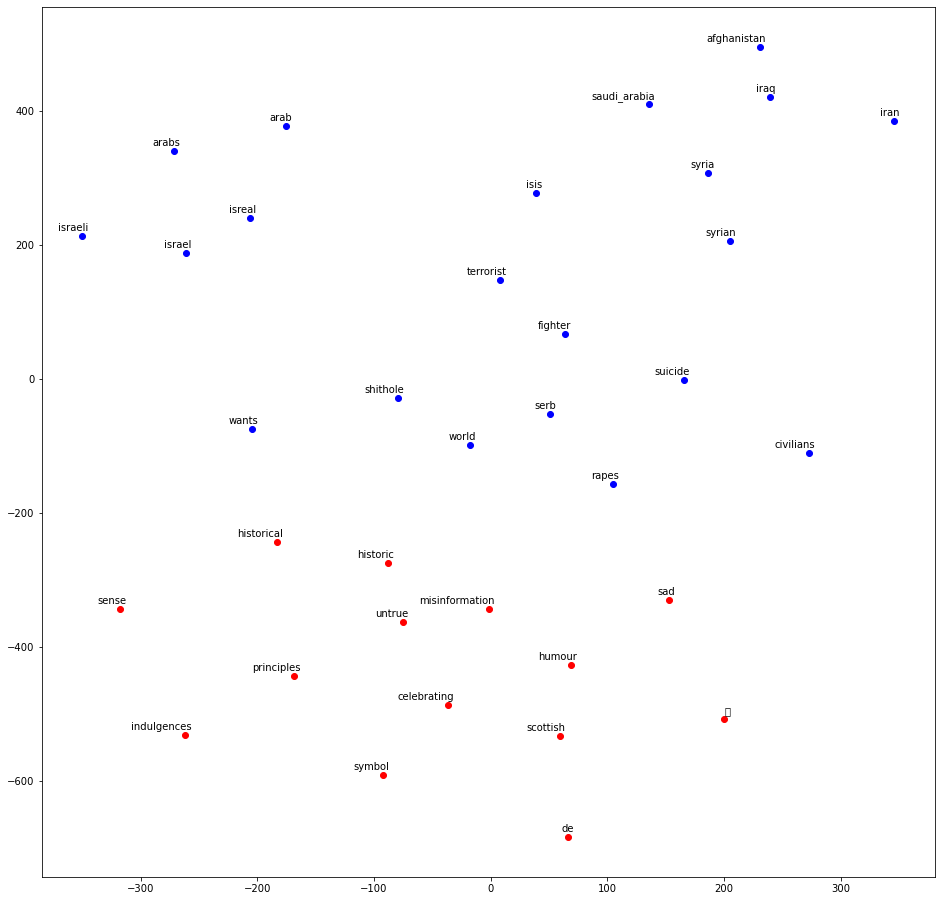

In [48]:
# t-SNE plot 
tsne = TSNE(perplexity=10, n_components=2, init='pca', n_iter=5000, random_state=42)
X_tsne = tsne.fit_transform(embs) # X_tsne = [[1,2], [3,4], [5,6]]


# split the X and Y coordinates
embsx = [x[0] for x in X_tsne]
embsy = [x[1] for x in X_tsne]
color = ['blue' if i == 0 else 'red' for i in y]

plt.figure(figsize=(16, 16)) 
for i in range(len(embs)):
    plt.scatter(embsx[i],embsy[i], c=color[i])
    plt.annotate( labels[i],
                  xy=(embsx[i],embsy[i]),
                  xytext=(6, 3),
                  textcoords='offset points',
                  ha='right',
                  va='bottom')
plt.show()

The first set of target sets I used was the religion target sets taken from Garg et al. 2018. Here we can see how the discussion of Islam, represented by the blue dots, is conducted on the subreddit. One main cluster relates to the Arab-Israeli conflict. Another deals with some of the most prominent Muslim-majority countries, while yet another deals with issues such as "terrorist" and "suicide". Contrastingly, the Christian data set has very little controversial topics.

This contrast between the treatment of religions shows how the more problematic elements of Islam are most strongly associated with it, while discussion on Christianity is more varied and diverse. In fact, because of the words present for Christianity, it seems there is no strong lean in the subreddit either for or against the religion. However, this lack of bias may be exactly what we are looking for. Islam is treated as a threat; words involving violence as well as countries with less than stellar international reputations (Syria) are among those in the plot. However, Christianity has no such worries perpetuated by the subreddit. The users of the subreddit are likely more comfortable with discussions of Christianity, indicating that the user base is likely majority Western.


<img src="figures/tsneMF.png" width="960" /> 
Figure 4: t-SNE using Male and Female target sets


The second set of target sets I used was the gender target sets taken from Nosek, Banaji, and Greenwald 2002. There is very little overlap here, with clear clusters. Based on the word embedding, one of the main clusters in how women are referenced in the subreddit is their traditional role in war. Historically, women have been rarely involved directly in war. Instead, they have been made victims of many different brutalities. These actions are referenced in the cluster containing "rape", "murder", "sexual", and "abuse". The plot indicates two variables of the subreddit's general worldview. Firstly, it focuses on war and conquest. This can be seen in the "glory" cluster of words biased towards the male target set, as well as the previous topic models. Secondly, women are often not treated as active participants in history. Many of the words seen in the t-SNE plot are passive and unrelated to historical feats or events involving women. Identity based words such as "gender" are also used along with more superficial terms like "hair". The usage of these words indicates a lack of historical discussion occurring about women in the comments of r/HistoryMemes, which could perpetuate the stereotype of women being unimportant in historical events.

## Conclusions

The use of topic modeling, word embeddings, and language bias tracking tools on the comments data from r/HistoryMemes has provided several key characteristics of the subreddit. Firstly, the subreddit considers itself to be quite open-minded and seeks to protect minority groups from negative targeted language. Commenters take an active role in showing their disapproval towards comments that pick on specific groups, especially when blurring historical fact as judged by the subreddit. 

Additionally, the subreddit mythologizes war, possibly to the point of fetishization. So much of the discourse is devoted to war and related topics, despite the vast array of other historical topics to choose from. This issue is also recognized by users of the subreddit, as seen in the below meme that falls under the "Meta" category. The subreddit falls under a form of Barthes's tridimensional pattern of myth (113). War signifies glory, and World War II functions as a type of availability heuristic due to its omnipresence in educational systems around the globe.

<img src="figures/metameme.png" width="800" /> 
Figure 5: Meme about the subreddit



Finally, the subreddit's language biases indicate that the majority of users approach history with a Western perspective, as shown by their familiarity with Christianity and fearful words surrounding Islam. There is a high probability that the majority of users are male as female-biased words often have little to do with history and are more related to history's impact on women.

Further research could explore the different angles within the biases. Using more specific topics could allow for better target sets to be created from the word embeddings model. As mentinoed in the Dataset Information section, post data was not integrated into this project. With the use of an image transcriber, data could be obtained that reveals what topics have the most posts made about them. This information could be used to support the conclusions this project had about World War II's role in the subreddit.

## References


Barthes, Roland. Mythologies: Roland Barthes. Hill and Wang, 1972.

Davison, Patrick. "The language of internet memes." *The social media reader* (2012): 120-134.

Ferrer, Xavier, et al. "Discovering and Categorising Language Biases in Reddit." *ICWSM*. 2021.

Garg, Nikhil, et al. "Word embeddings quantify 100 years of gender and ethnic stereotypes." *Proceedings of the National Academy of Sciences* 115.16 (2018): E3635-E3644.

Nosek, Brian A., Mahzarin R. Banaji, and Anthony G. Greenwald. "Harvesting implicit group attitudes and beliefs from a demonstration web site." *Group Dynamics: Theory, Research, and Practice* 6.1 (2002): 101.

Vidal, Clément. "What is a worldview?." *De wetenschappen en het creatieve aspect van de werkelijkheid*. 2008.
